## Step 0: Import Libraries and Configuration

Load necessary libraries and initialize configuration parameters

In [1]:
import warnings
warnings.filterwarnings('ignore')

from modules.config import cfg
cfg.use_vmd = False  # Set to True to enable VMD (requires vmdpy)

try:
    import ruptures as rpt
    RUPTURES_AVAILABLE = True
except ImportError:
    RUPTURES_AVAILABLE = False
    warnings.warn("ruptures library not available. Change-point detection will use derivative method only.")

print("Configuration loaded")
print(f"  Sampling rate: {cfg.fs} Hz")
print(f"  Alpha band: {cfg.alpha[0]}-{cfg.alpha[1]} Hz")
print(f"  Beta band: {cfg.beta[0]}-{cfg.beta[1]} Hz")
print(f"  Bridge duration: {cfg.bridge_sec} sec")
print(f"  Feature window: {cfg.win_sec} sec (step: {cfg.step_sec} sec)")
print(f"  Ruptures available: {RUPTURES_AVAILABLE}")

Configuration loaded
  Sampling rate: 500 Hz
  Alpha band: 8-13 Hz
  Beta band: 13-30 Hz
  Bridge duration: 10.0 sec
  Feature window: 2.0 sec (step: 1.0 sec)
  Ruptures available: True


## Step 1: Subject Configuration

Define subjects to process (requires both B4 and A5 files)

In [2]:
subjects = {
    'Subject_1': {
        'b4': 'DATASET/Bhargavi_B4_08122025.csv',
        'a5': 'DATASET/Bhargavi_A5_08122025.csv'
    },
    'Subject_2': {
        'b4': 'DATASET/Ayush_B4_14102025.csv',
        'a5': 'DATASET/Ayush_A5_14102025.csv'
    },
    'Subject_3': {
        'b4': 'DATASET/Jay_B4_08120205.csv',
        'a5': 'DATASET/Jay_A5_08122025.csv'
    },
    'Subject_4': {
        'b4': None,  # Missing B4 file
        'a5': 'DATASET/Kanchan_A5_08122025.csv'
    },
    'Subject_5': {
        'b4': None,  # Missing B4 file
        'a5': 'DATASET/Samiran_A5_08122025.csv'
    }
}

# Filter subjects with both B4 and A5 files
valid_subjects = {name: paths for name, paths in subjects.items() 
                  if paths['b4'] is not None and paths['a5'] is not None}

print(f"Valid subjects with both B4 and A5 files: {list(valid_subjects.keys())}")

Valid subjects with both B4 and A5 files: ['Subject_1', 'Subject_2', 'Subject_3']


## Step 2: Data Loading and Preprocessing

Load raw signals and apply:
- Bandpass filters (or VMD if enabled)
- 30-minute exclusion zone for A5 data (removes post-meal lag)


LOADING DATA: Subject_1
  ⚠ Warning: A5 file too short (150500 samples), skipping exclusion
B4: 156000 samples (312.0 sec)
A5: 150500 samples (301.0 sec)


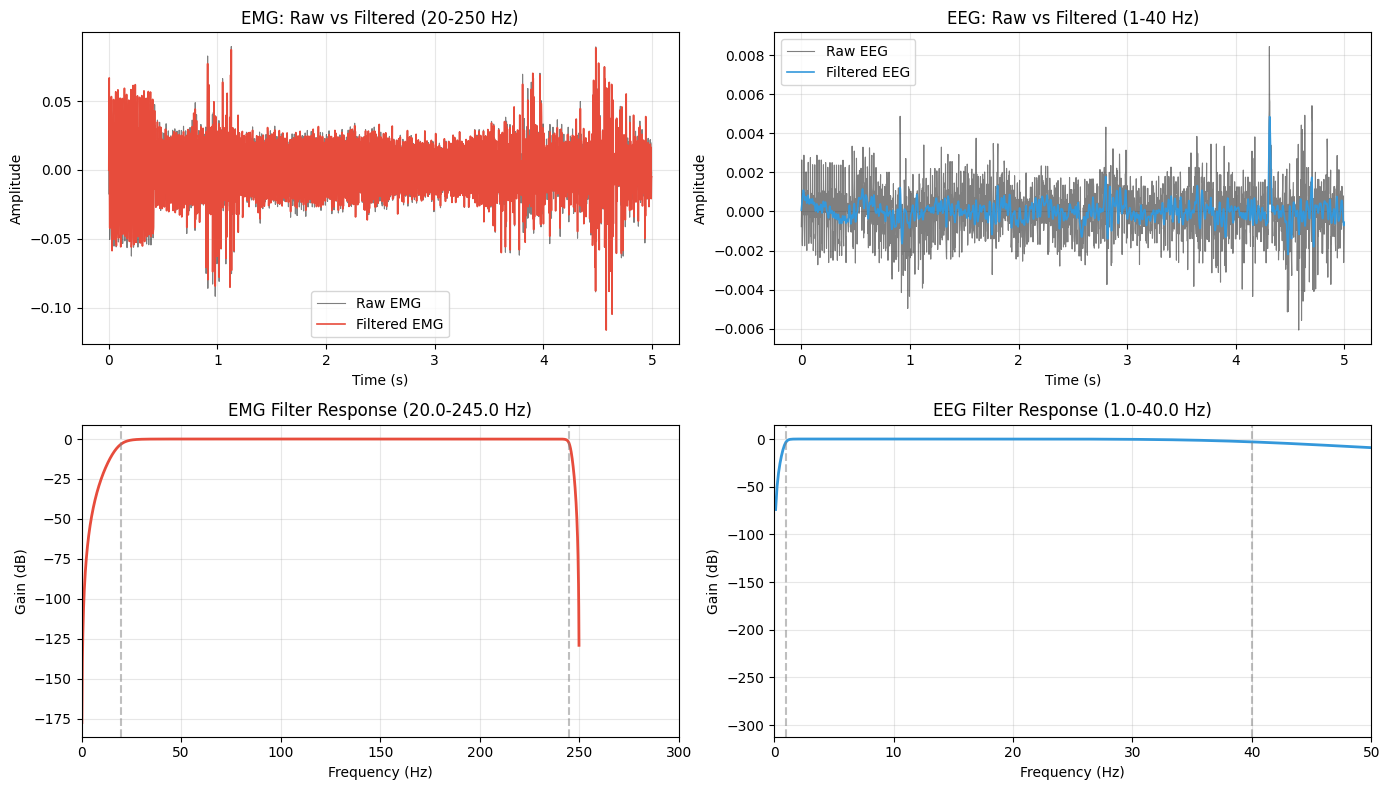

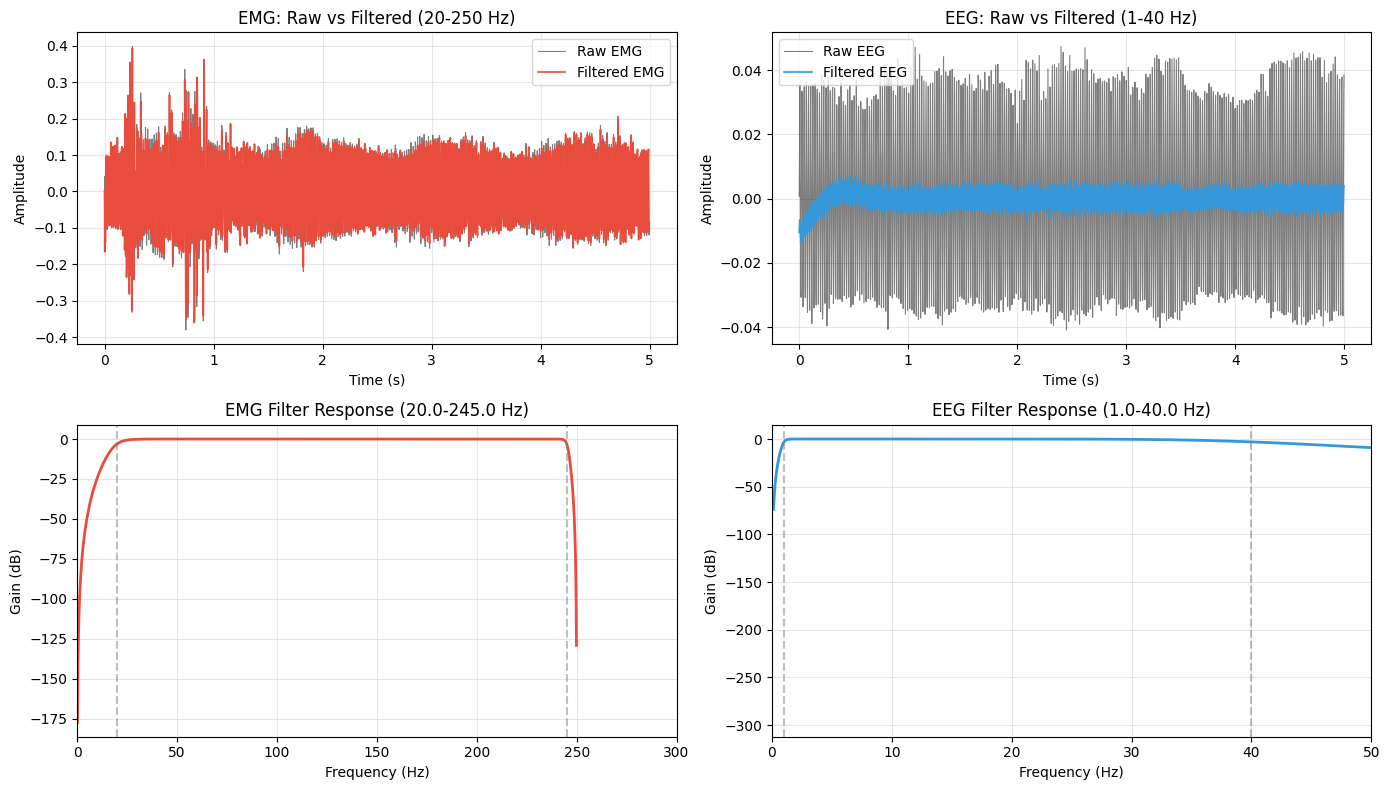


LOADING DATA: Subject_2
  ⚠ Warning: A5 file too short (150000 samples), skipping exclusion
B4: 150000 samples (300.0 sec)
A5: 150000 samples (300.0 sec)


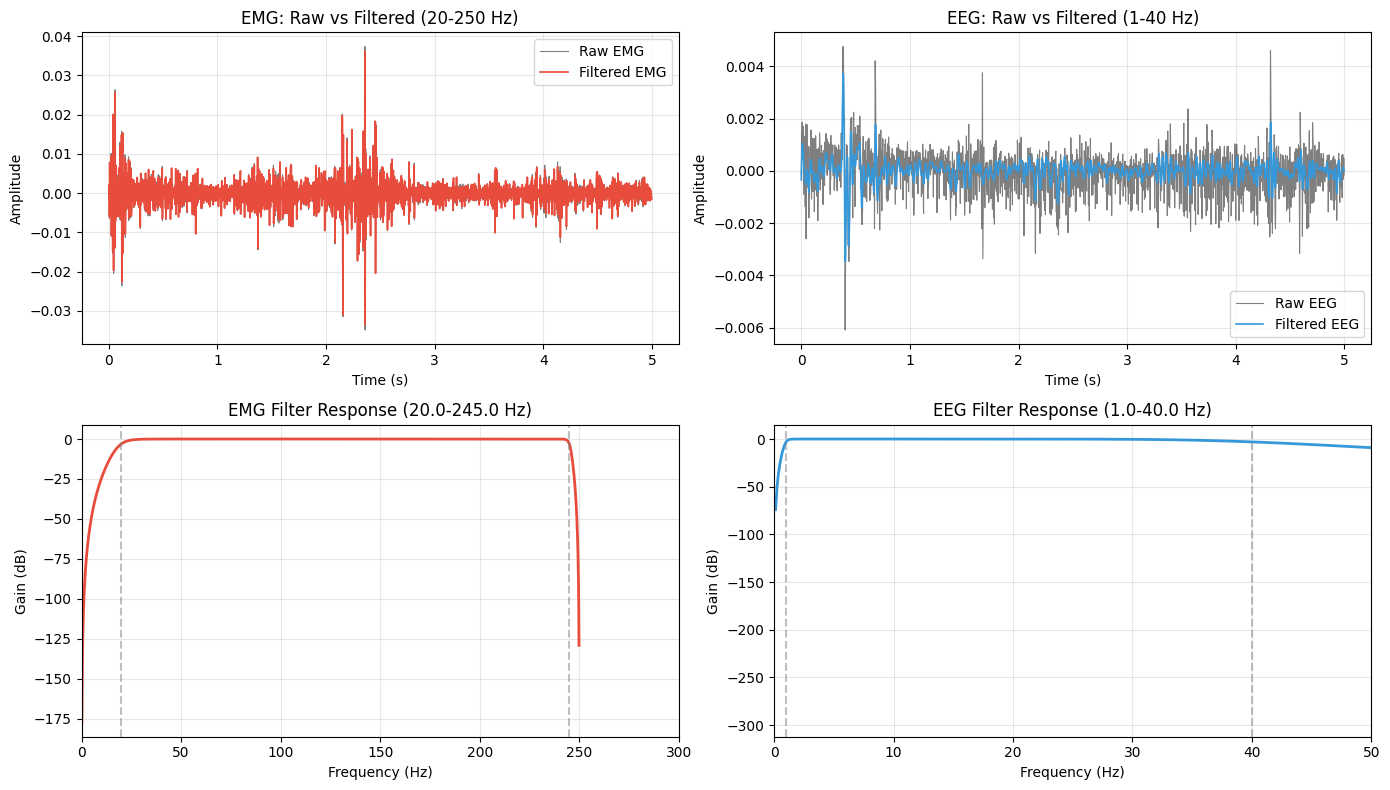

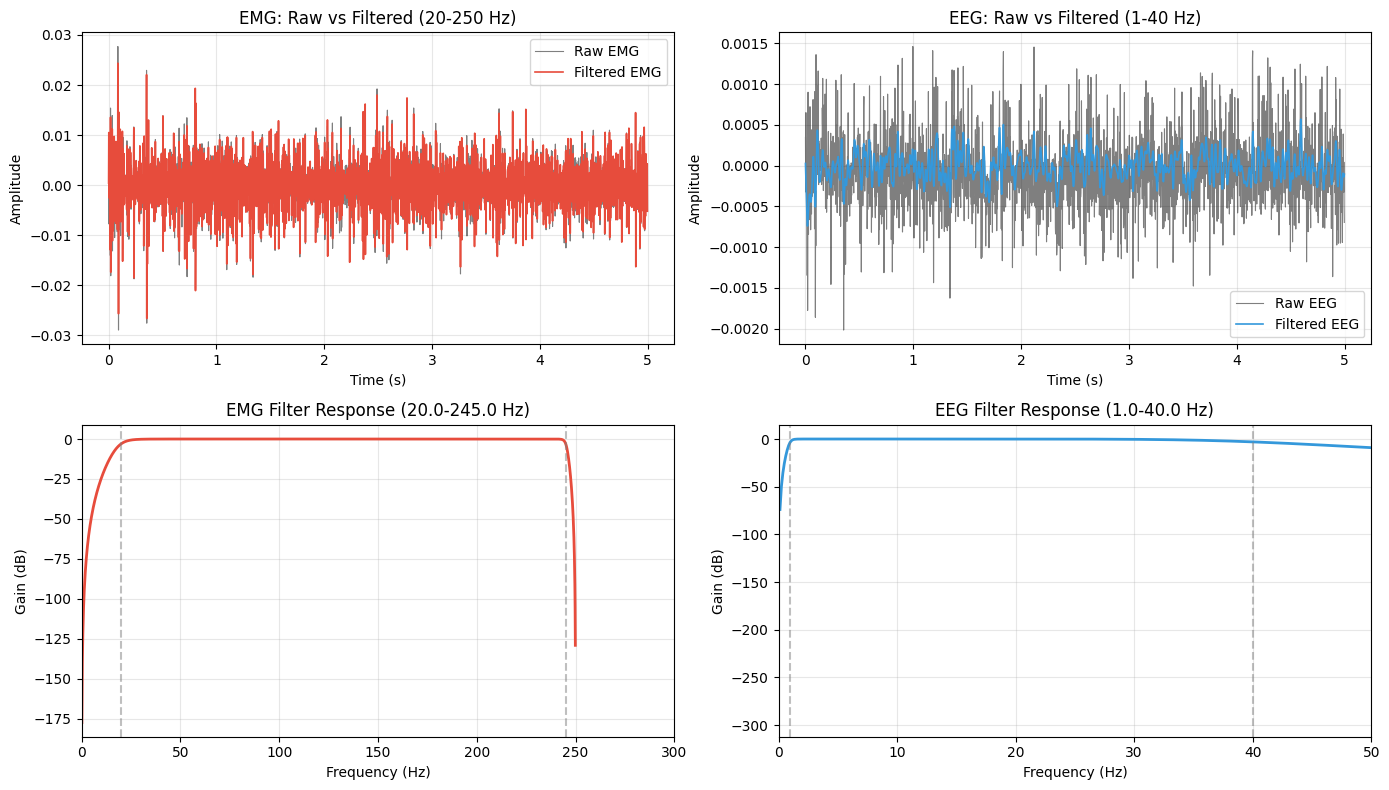


LOADING DATA: Subject_3
  ⚠ Warning: A5 file too short (150000 samples), skipping exclusion
B4: 150000 samples (300.0 sec)
A5: 150000 samples (300.0 sec)


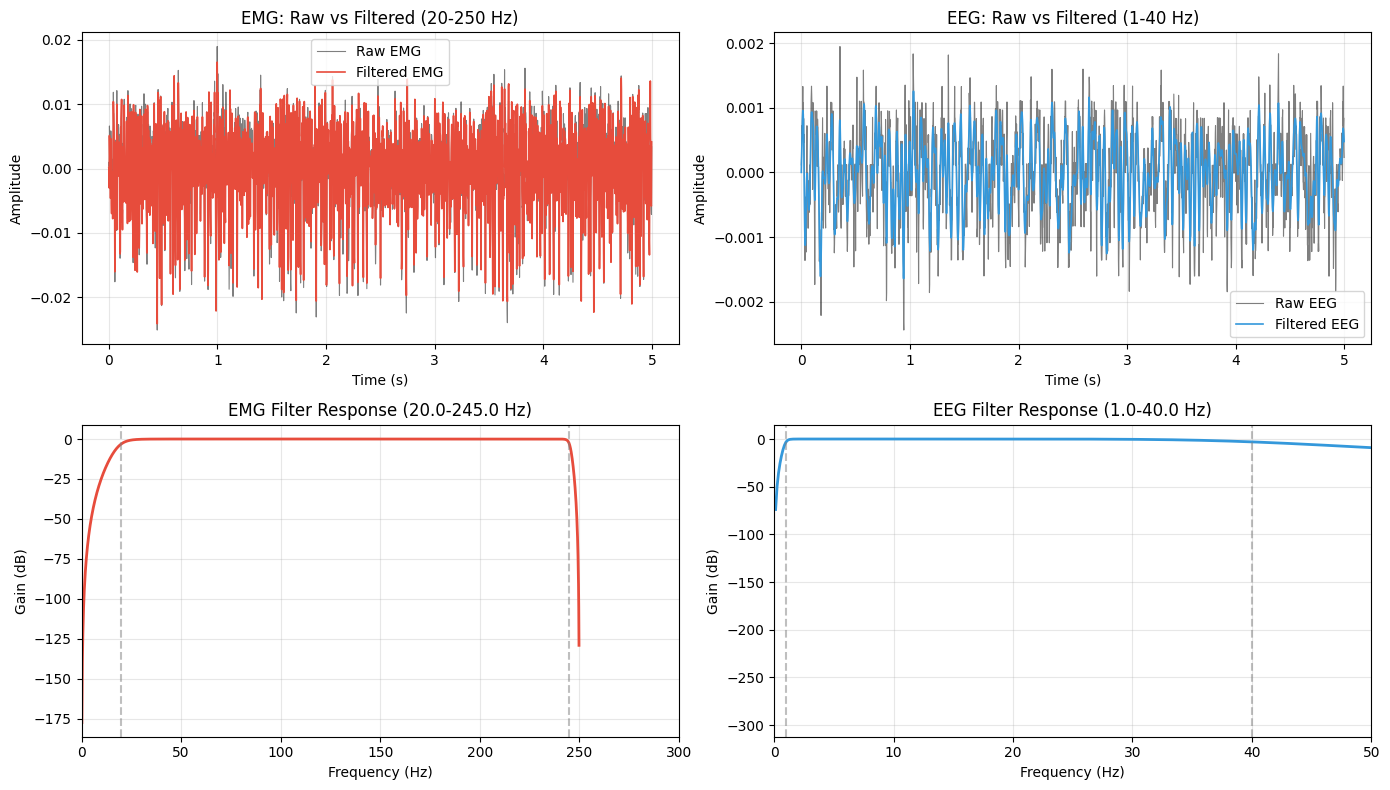

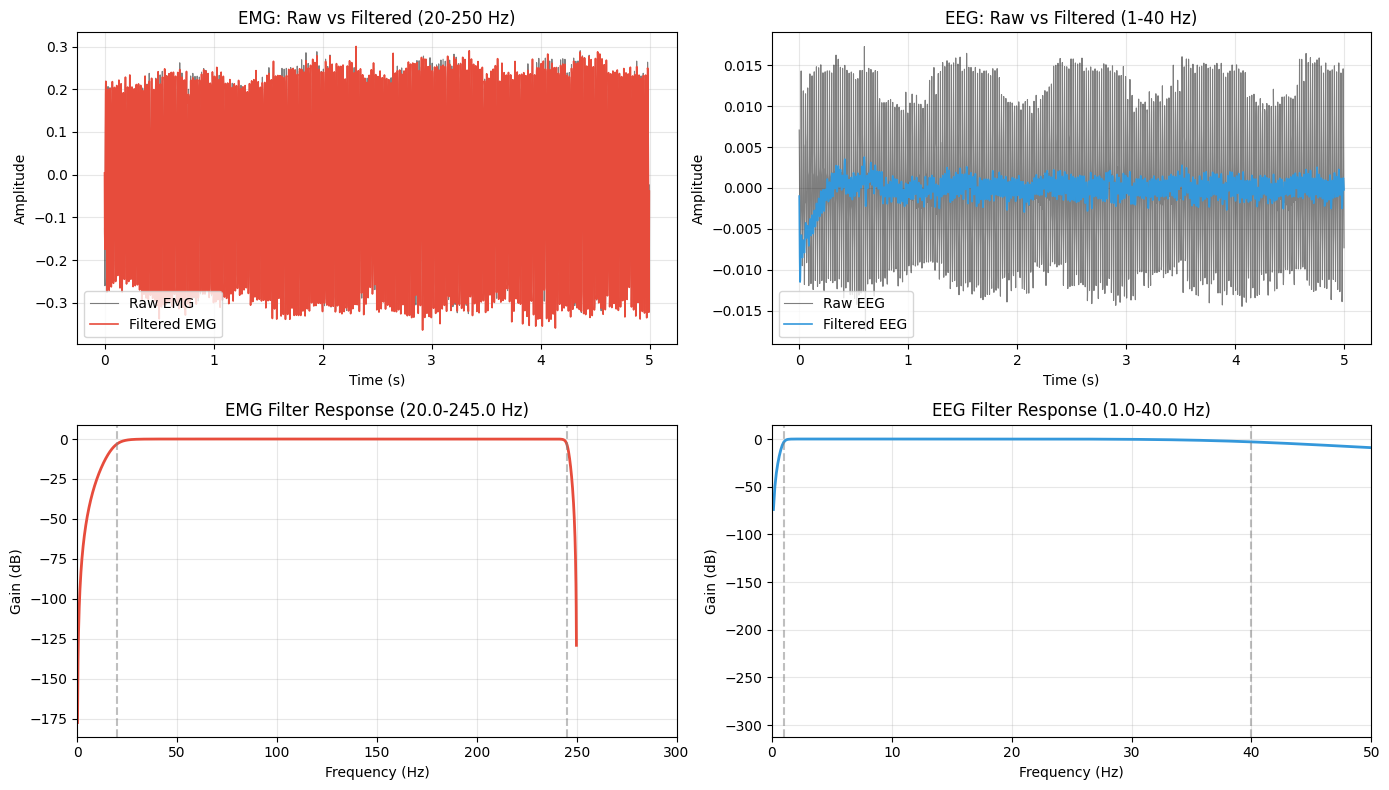


✓ Preprocessing complete for 3 subjects with exclusion zones


In [3]:
from modules.preprocessing import load_signal, preprocess_signals, plot_filter_verification
import matplotlib.pyplot as plt
import numpy as np
import os

# Store preprocessed data for all subjects
preprocessed_data = {}

os.makedirs('output', exist_ok=True)

for name, paths in valid_subjects.items():
    print(f"\n{'='*70}")
    print(f"LOADING DATA: {name}")
    print('='*70)
    
    # Load signals with exclusion zone for A5 (removes 30-min post-meal lag)
    b4_raw = load_signal(paths['b4'])
    a5_raw = load_signal(paths['a5'], apply_exclusion=True)  # ← EXCLUSION ZONE ENABLED
    
    # Fix: Overwrite the broken Counter with a continuous index
    b4_raw['Counter'] = np.arange(len(b4_raw))
    a5_raw['Counter'] = np.arange(len(a5_raw))
    
    print(f"B4: {len(b4_raw)} samples ({len(b4_raw)/cfg.fs:.1f} sec)")
    print(f"A5: {len(a5_raw)} samples ({len(a5_raw)/cfg.fs:.1f} sec)")
    
    # Apply filters (VMD or bandpass depending on cfg.use_vmd)
    b4_filt = preprocess_signals(b4_raw, cfg.fs)
    a5_filt = preprocess_signals(a5_raw, cfg.fs)
    
    preprocessed_data[name] = {
        'b4_raw': b4_raw,
        'a5_raw': a5_raw,
        'b4_filt': b4_filt,
        'a5_filt': a5_filt
    }
    
    # Plot filter verification for B4
    b4_date = os.path.splitext(os.path.basename(paths['b4']))[0].split('_')[-1]
    fig = plot_filter_verification(b4_raw, b4_filt, cfg.fs)
    fig.savefig(f'output/{name}_B4_{b4_date}.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    # Plot filter verification for A5
    a5_date = os.path.splitext(os.path.basename(paths['a5']))[0].split('_')[-1]
    fig = plot_filter_verification(a5_raw, a5_filt, cfg.fs)
    fig.savefig(f'output/{name}_A5_{a5_date}.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n✓ Preprocessing complete for {len(preprocessed_data)} subjects with exclusion zones")

## Step 3: Signal Bridge Generation

Create smooth transitions between B4 and A5 states using sigmoidal interpolation


GENERATING ROBUST SIGMOIDAL BRIDGE: Subject_1
Combined: 311500 samples (623.0 sec)
Bridge: 5000 samples (10.0 sec) - 5000 windows expected


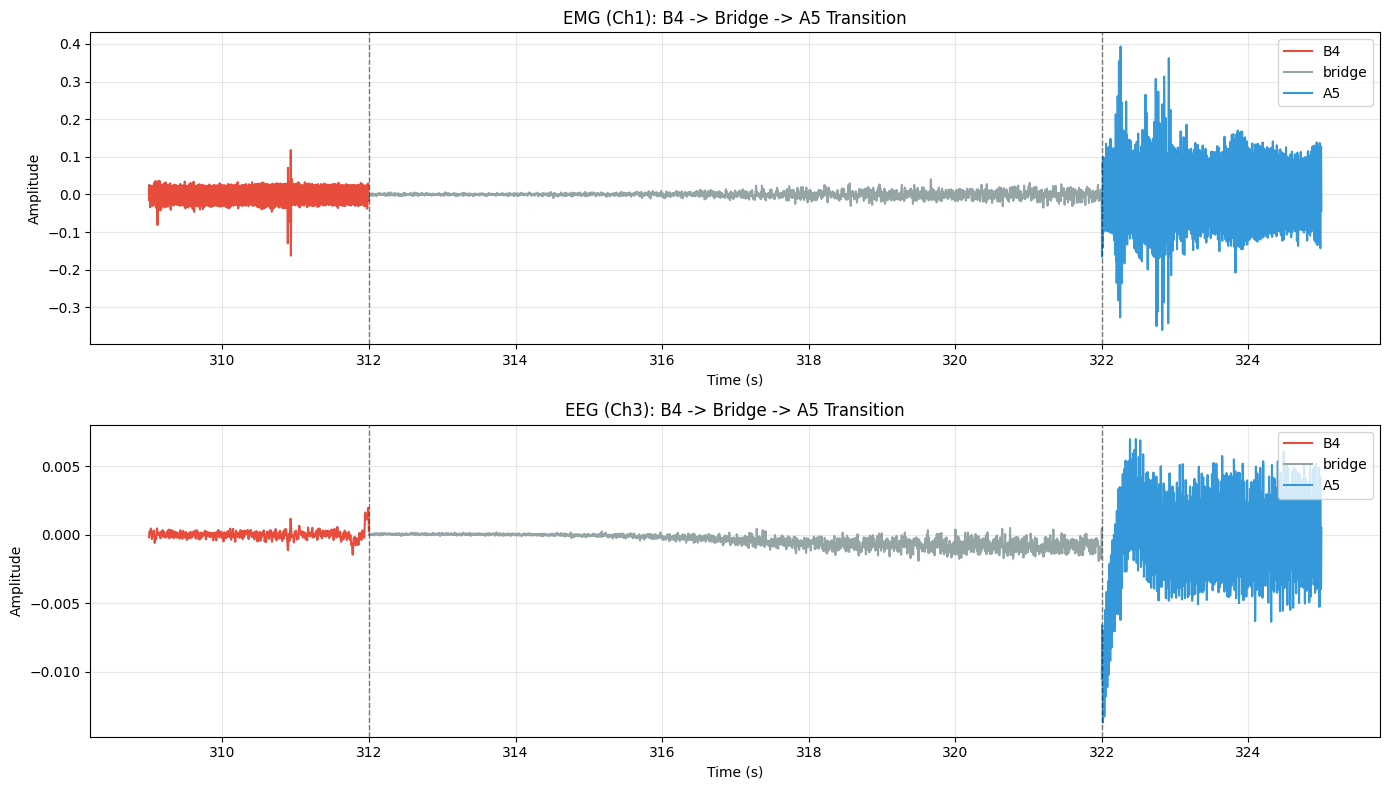


GENERATING ROBUST SIGMOIDAL BRIDGE: Subject_2
Combined: 305000 samples (610.0 sec)
Bridge: 5000 samples (10.0 sec) - 5000 windows expected


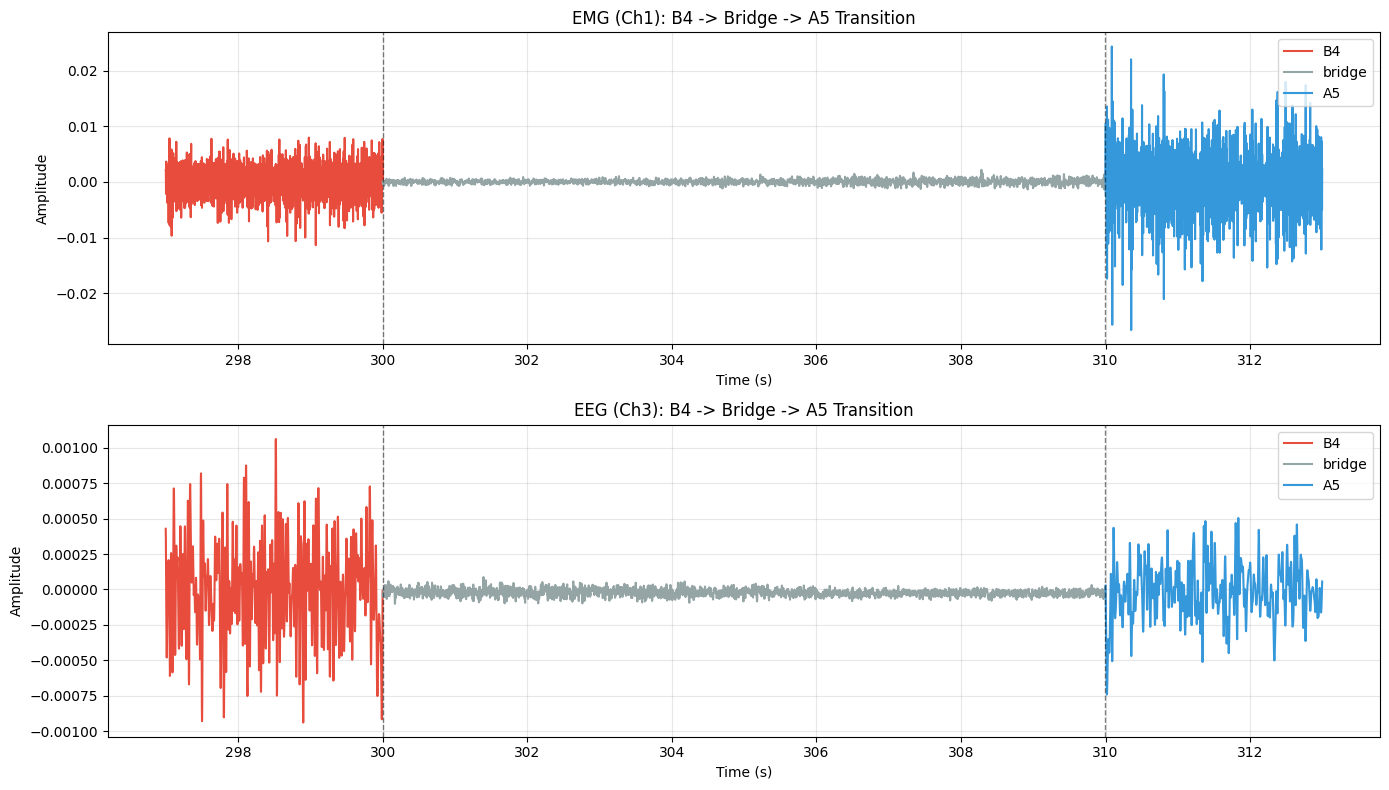


GENERATING ROBUST SIGMOIDAL BRIDGE: Subject_3
Combined: 305000 samples (610.0 sec)
Bridge: 5000 samples (10.0 sec) - 5000 windows expected


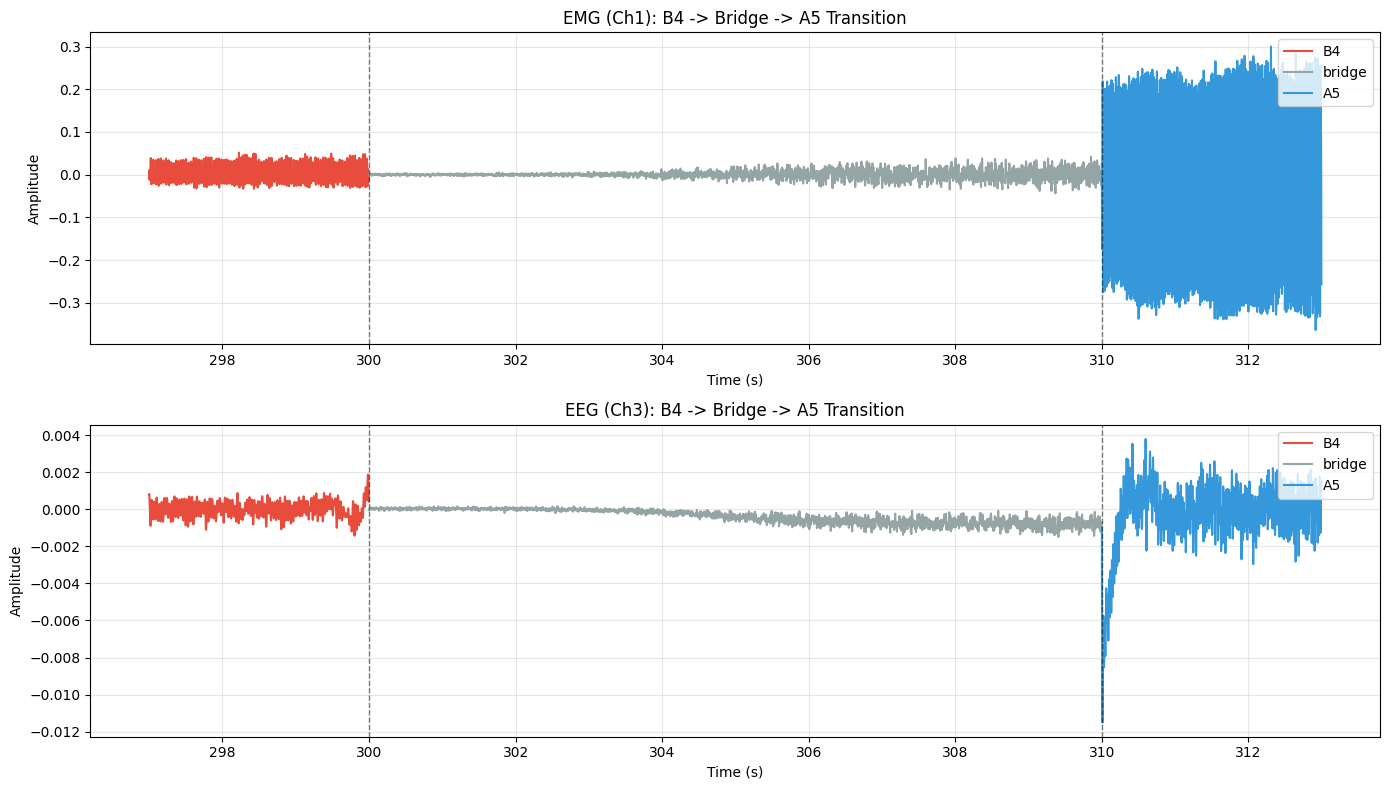



Robust sigmoidal bridge generation complete for 3 subjects


In [4]:
from modules.bridge import combine_with_bridge, plot_bridge_visualization

# Store combined signals
combined_data = {}

for name in preprocessed_data.keys():
    print(f"\n{'='*70}")
    print(f"GENERATING ROBUST SIGMOIDAL BRIDGE: {name}")
    print('='*70)
    
    data = preprocessed_data[name]
    # Use robust sigmoidal bridge with increased duration for PCA visibility
    combined = combine_with_bridge(
        data['b4_filt'], 
        data['a5_filt'], 
        cfg.fs, 
        cfg.bridge_sec, 
        noise_scale=cfg.bridge_noise_scale,
        use_sigmoidal=cfg.bridge_use_sigmoidal
    )
    combined_data[name] = combined
    
    # Calculate bridge statistics
    bridge_samples = (combined['segment'] == 'bridge').sum()
    bridge_duration = bridge_samples / cfg.fs
    
    print(f"Combined: {len(combined)} samples ({len(combined)/cfg.fs:.1f} sec)")
    print(f"Bridge: {bridge_samples} samples ({bridge_duration:.1f} sec) - {bridge_samples} windows expected")
    
    # Plot bridge visualization
    fig = plot_bridge_visualization(combined, cfg.fs)
    fig.savefig(f'output/{name}_bridge_transition.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nRobust sigmoidal bridge generation complete for {len(combined_data)} subjects")

## Step 4: Feature Extraction

Extract EEG spectral features and EMG time-domain features


EXTRACTING FEATURES: Subject_1
Features: 622 windows


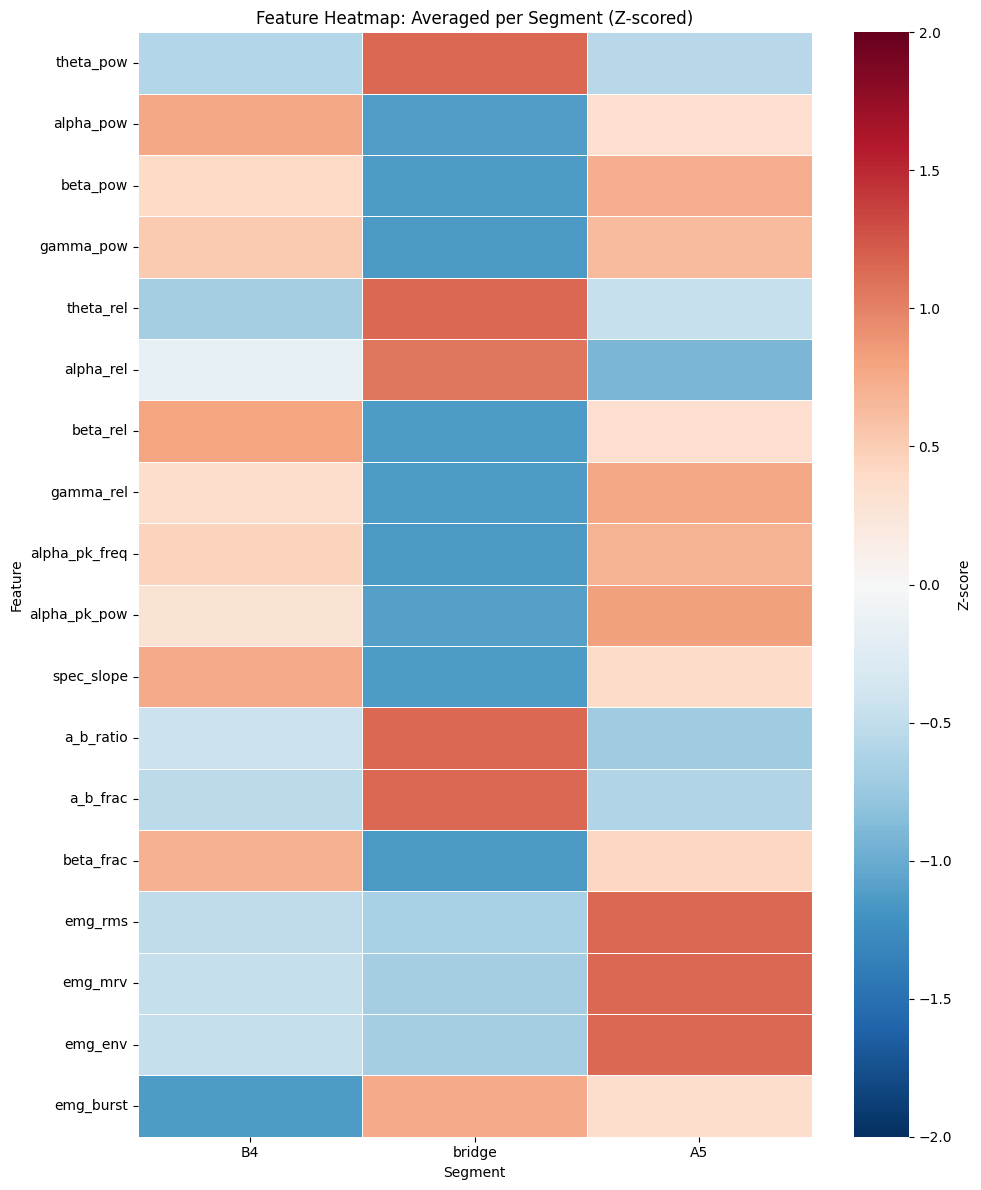

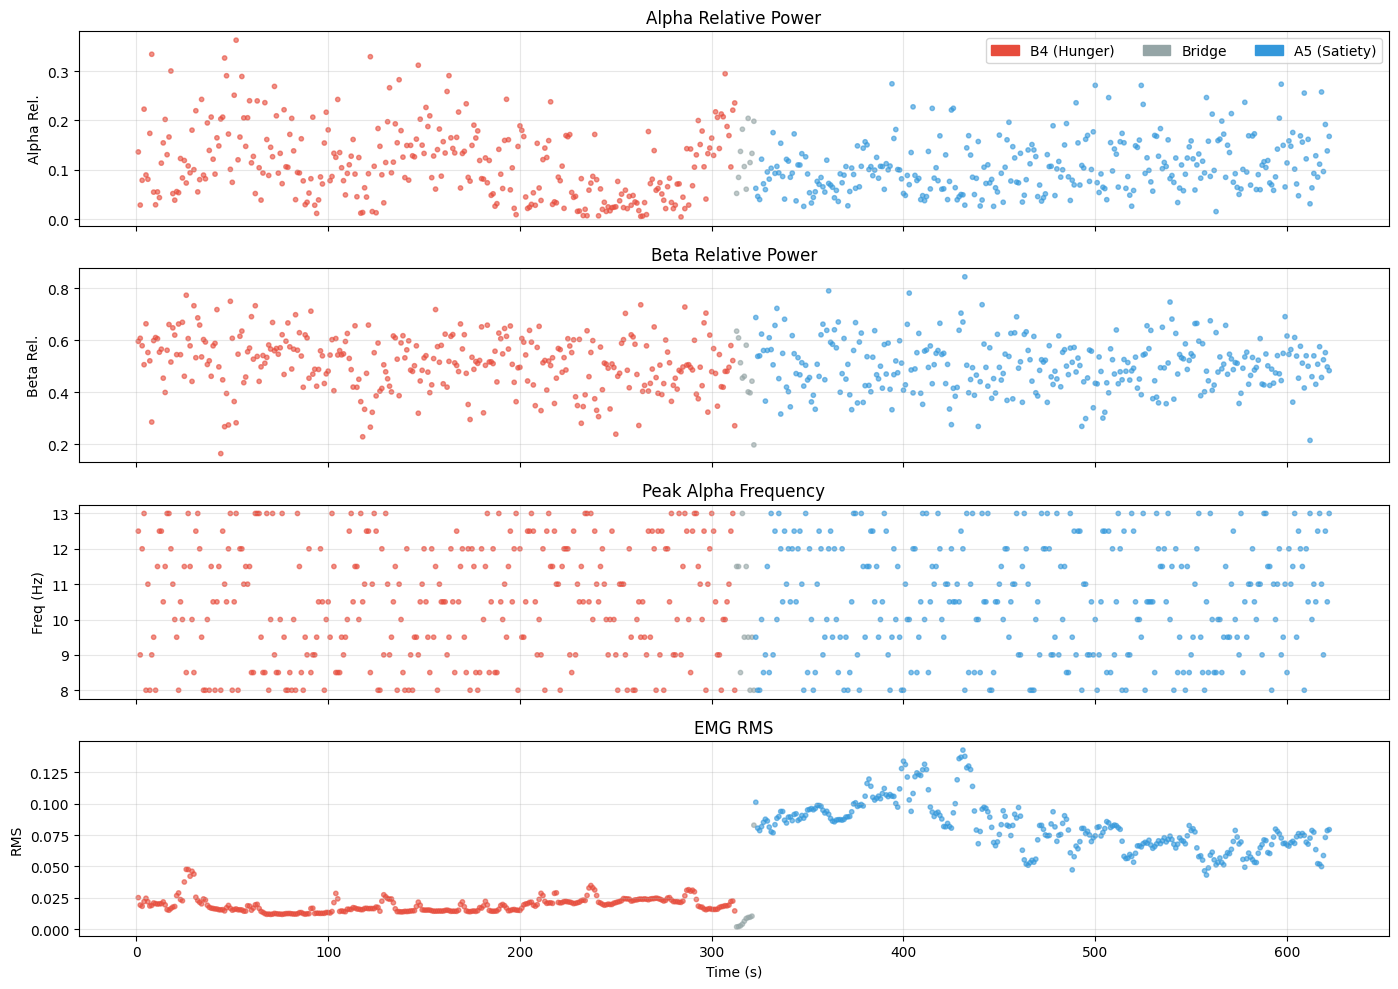


EXTRACTING FEATURES: Subject_2
Features: 609 windows


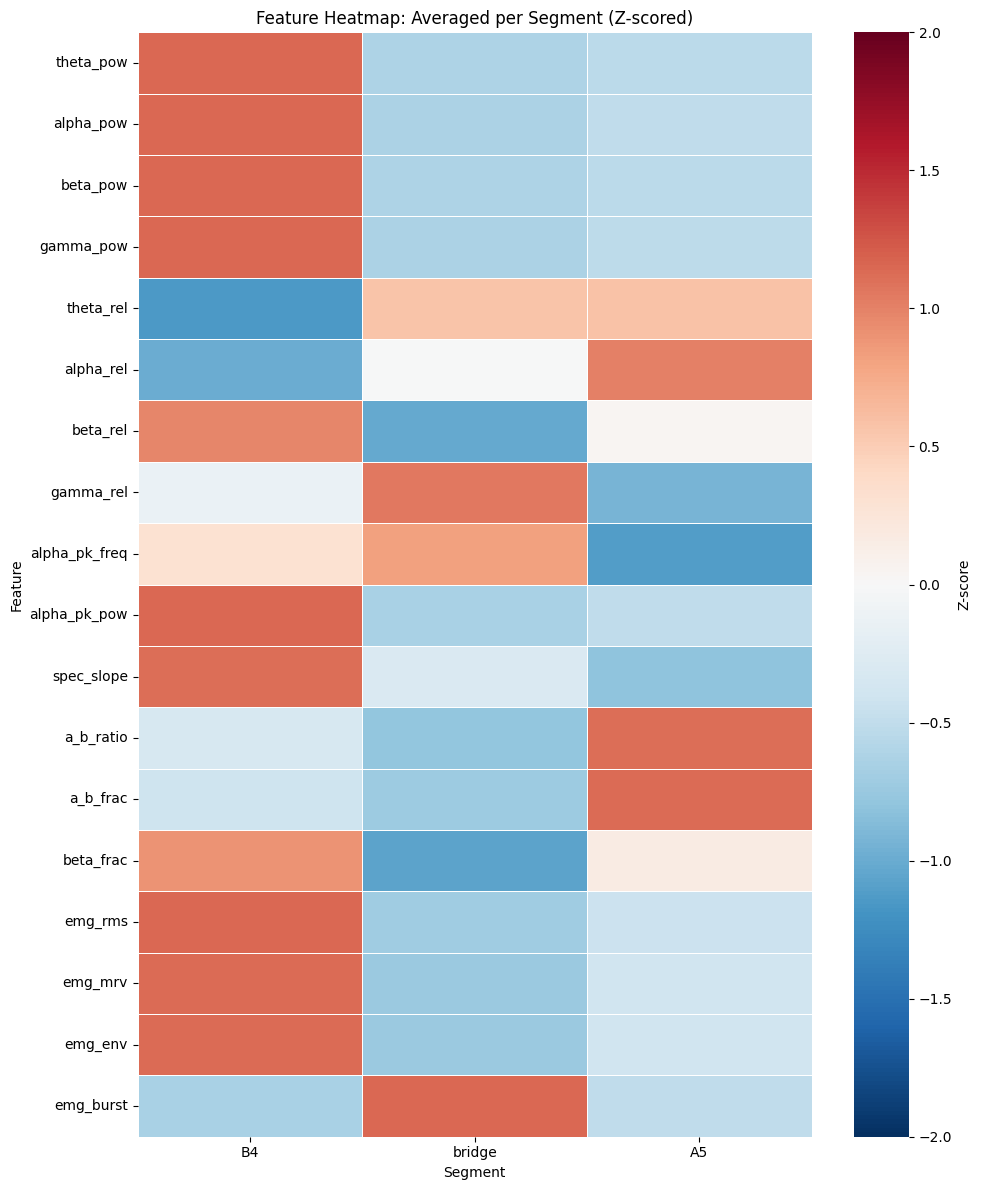

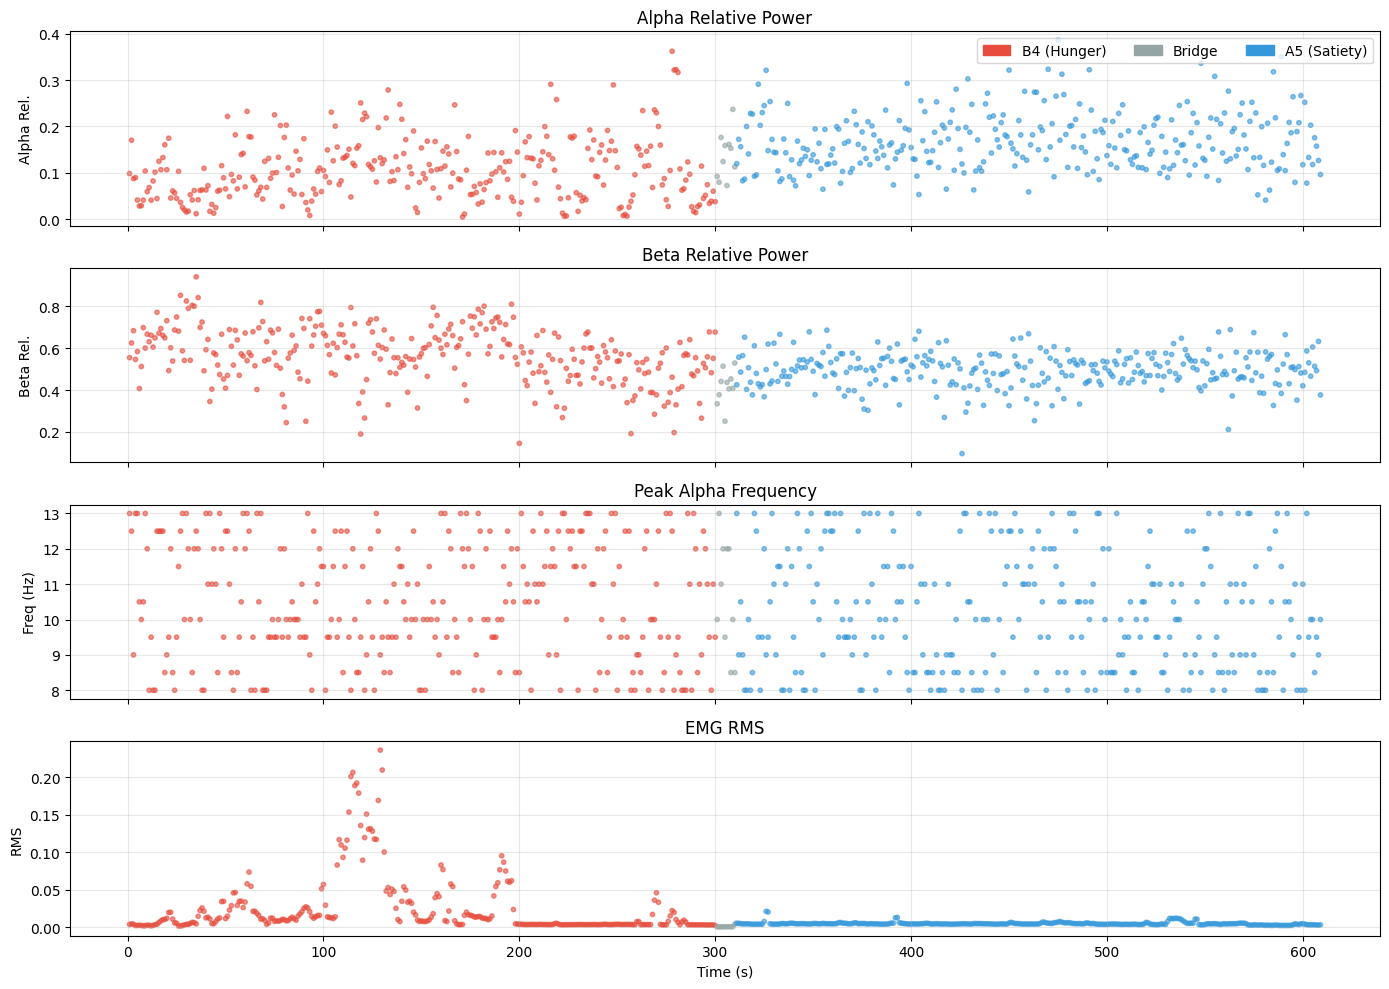


EXTRACTING FEATURES: Subject_3
Features: 609 windows


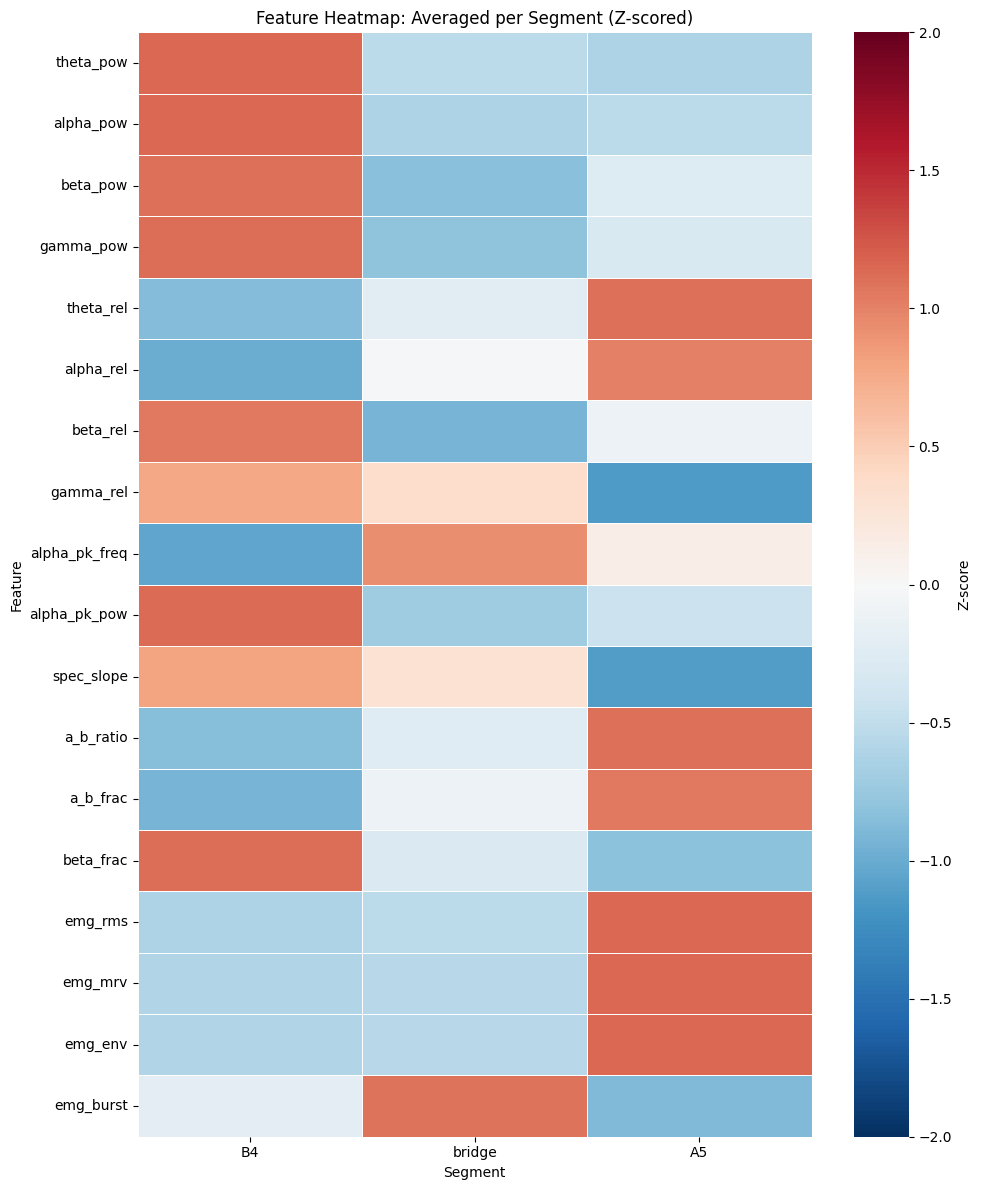

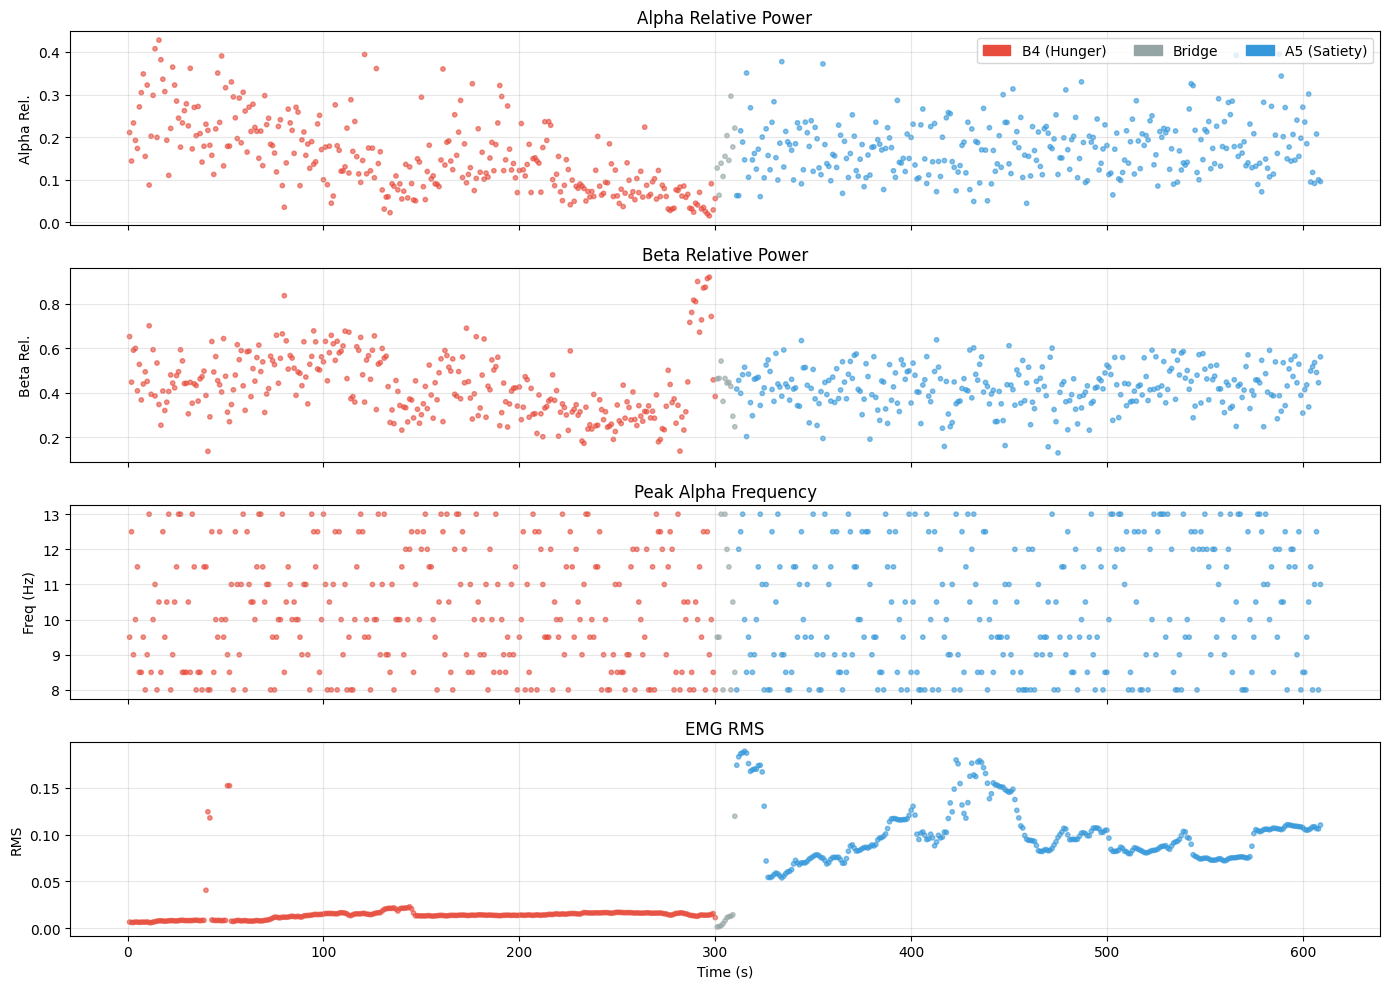



Feature extraction complete for 3 subjects


In [5]:
from modules.feature_extraction import extract_all_features, plot_feature_heatmap, plot_features_timeline
import matplotlib.pyplot as plt

# Store features for all subjects
features_data = {}

for name in combined_data.keys():
    print(f"\n{'='*70}")
    print(f"EXTRACTING FEATURES: {name}")
    print('='*70)
    
    combined = combined_data[name]
    
    features = extract_all_features(
        combined,
        cfg.fs,
        cfg.win_sec,
        cfg.step_sec
    )
    features_data[name] = features
    
    print(f"Features: {len(features)} windows")
    
    # Plot feature heatmap
    fig = plot_feature_heatmap(features)
    fig.savefig(f'output/{name}_feature_heatmap.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    # Plot feature timeline
    fig = plot_features_timeline(features)
    fig.savefig(f'output/{name}_feature_timeline.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nFeature extraction complete for {len(features_data)} subjects")

## Step 5: Dynamic Feature Bridge (Optional)

Apply Mahalanobis-based dynamic bridge at feature level

*Note: This step modifies features_data. Skip if not needed for medical validation.*

In [6]:
from modules.feature_bridge import generate_dynamic_bridge, DynamicBridgeParams
import pandas as pd

# Apply dynamic feature-level bridge per subject
for name in features_data.keys():
    print(f"\n{'='*70}")
    print(f"DYNAMIC FEATURE BRIDGE: {name}")
    print('='*70)
    feat = features_data[name]

    # Separate segments and select tails/heads
    b4 = feat[feat['segment'] == 'B4'].copy()
    a5 = feat[feat['segment'] == 'A5'].copy()

    tail_n = min(getattr(cfg, 'dyn_tail_windows', 20), len(b4), len(a5))
    b4_tail = b4.tail(tail_n)
    a5_head = a5.head(tail_n)

    # Start time immediately after last B4 window
    t0 = float(b4['time'].iloc[-1] + cfg.step_sec)

    params = DynamicBridgeParams(
        step_sec=cfg.step_sec,
        base_time=getattr(cfg, 'dyn_base_sec', 5.0),
        alpha=getattr(cfg, 'dyn_alpha', 1.0),
        min_time=getattr(cfg, 'dyn_min_sec', 5.0),
        max_time=getattr(cfg, 'dyn_max_sec', 20.0),
        jitter=getattr(cfg, 'dyn_noise_jitter', 0.15),
        random_state=cfg.random_state,
    )

    bridge_df = generate_dynamic_bridge(b4_tail, a5_head, params=params, start_time=t0)

    # Ensure B4 and A5 have proper hard labels (1=hungry, 0=satiated)
    if 'label' not in b4.columns or b4['label'].isna().any():
        b4['label'] = 1  # B4 = Hungry
    if 'label' not in a5.columns or a5['label'].isna().any():
        a5['label'] = 0  # A5 = Satiated
    
    # Add soft_label column to B4 and A5 for consistency (same as hard labels)
    b4['soft_label'] = 1.0
    a5['soft_label'] = 0.0

    # Compose new features: B4 + dynamic BR + A5 (drop existing bridge if any)
    new_feat = pd.concat([b4, bridge_df, a5], ignore_index=True)

    # Ensure time is strictly increasing and segments contiguous
    features_data[name] = new_feat

    print(f"  Tail windows used: {tail_n}")
    print(f"  Dynamic bridge windows: {len(bridge_df)} (~{len(bridge_df)*cfg.step_sec:.1f} sec)")
    print(f"  New total windows: {len(new_feat)}")
    print(f"  B4 labels: {b4['label'].unique()}, A5 labels: {a5['label'].unique()}")
    print(f"  Bridge soft_labels: {bridge_df['soft_label'].min():.2f} to {bridge_df['soft_label'].max():.2f}")

print("\nDynamic feature bridge generation complete.")


DYNAMIC FEATURE BRIDGE: Subject_1
  Tail windows used: 20
  Dynamic bridge windows: 7 (~7.0 sec)
  New total windows: 619
  B4 labels: [1.], A5 labels: [0.]
  Bridge soft_labels: 0.00 to 1.00

DYNAMIC FEATURE BRIDGE: Subject_2
  Tail windows used: 20
  Dynamic bridge windows: 7 (~7.0 sec)
  New total windows: 606
  B4 labels: [1.], A5 labels: [0.]
  Bridge soft_labels: 0.00 to 1.00

DYNAMIC FEATURE BRIDGE: Subject_3
  Tail windows used: 20
  Dynamic bridge windows: 7 (~7.0 sec)
  New total windows: 606
  B4 labels: [1.], A5 labels: [0.]
  Bridge soft_labels: 0.00 to 1.00

Dynamic feature bridge generation complete.


## Step 6: Hunger Index Construction

Build weighted and PCA-based hunger indices for baseline analysis


BUILDING HUNGER INDEX: Subject_1


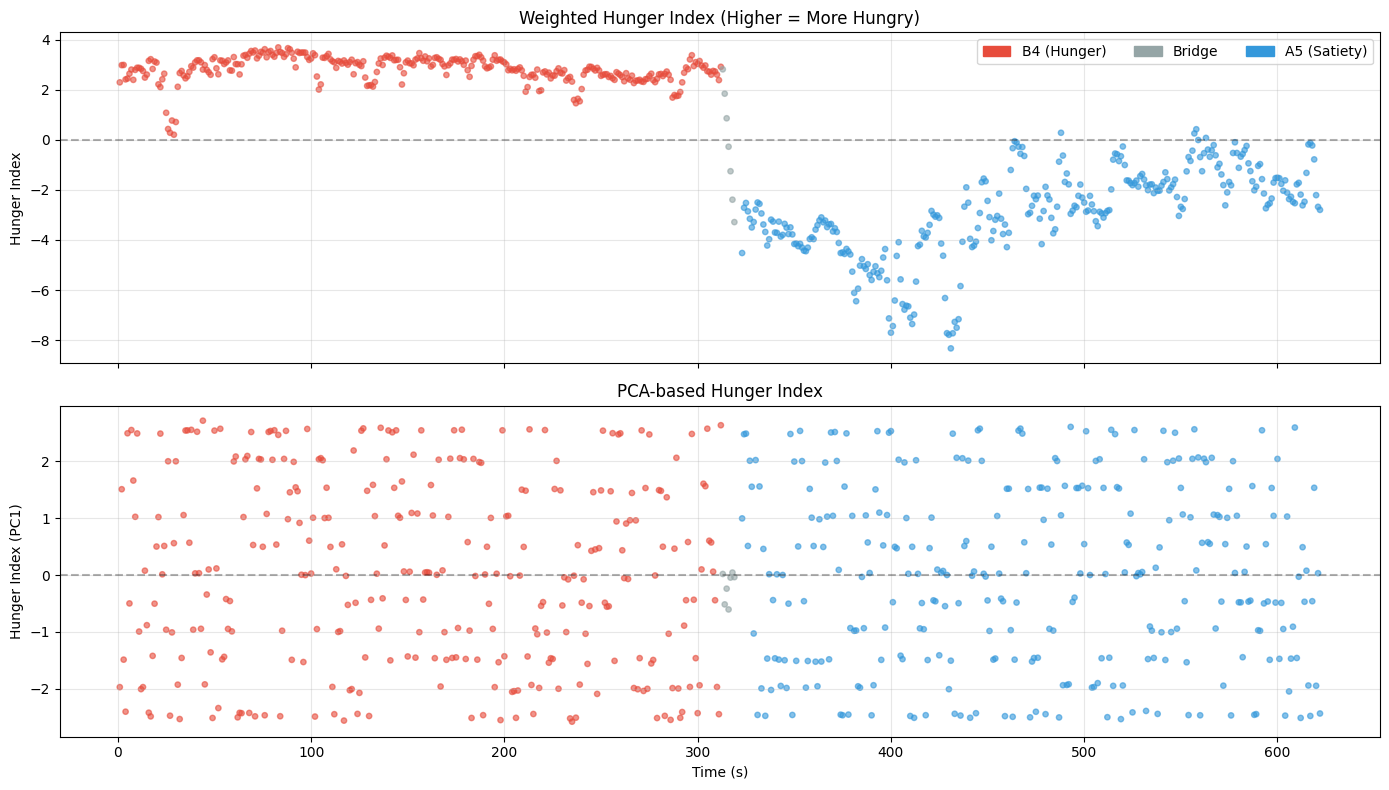


BUILDING HUNGER INDEX: Subject_2


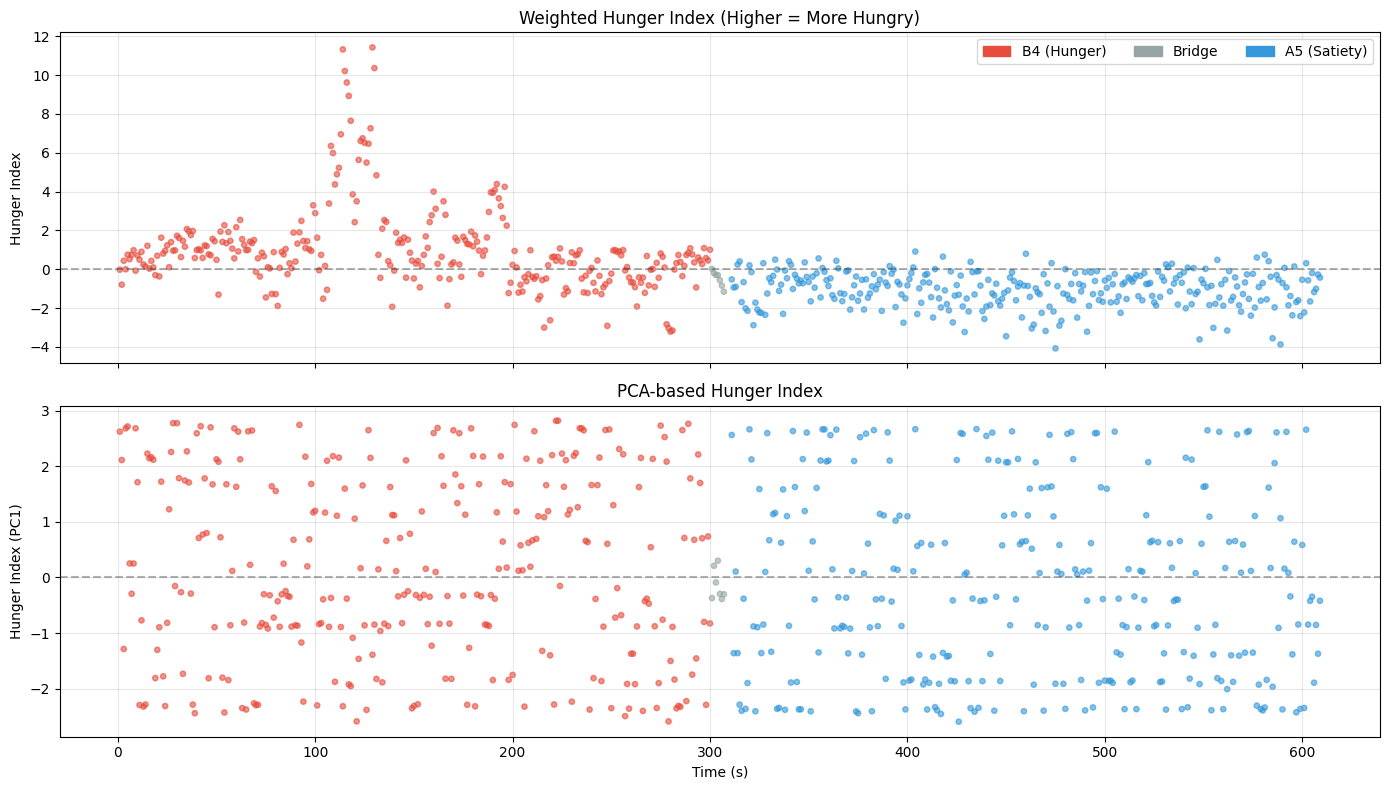


BUILDING HUNGER INDEX: Subject_3


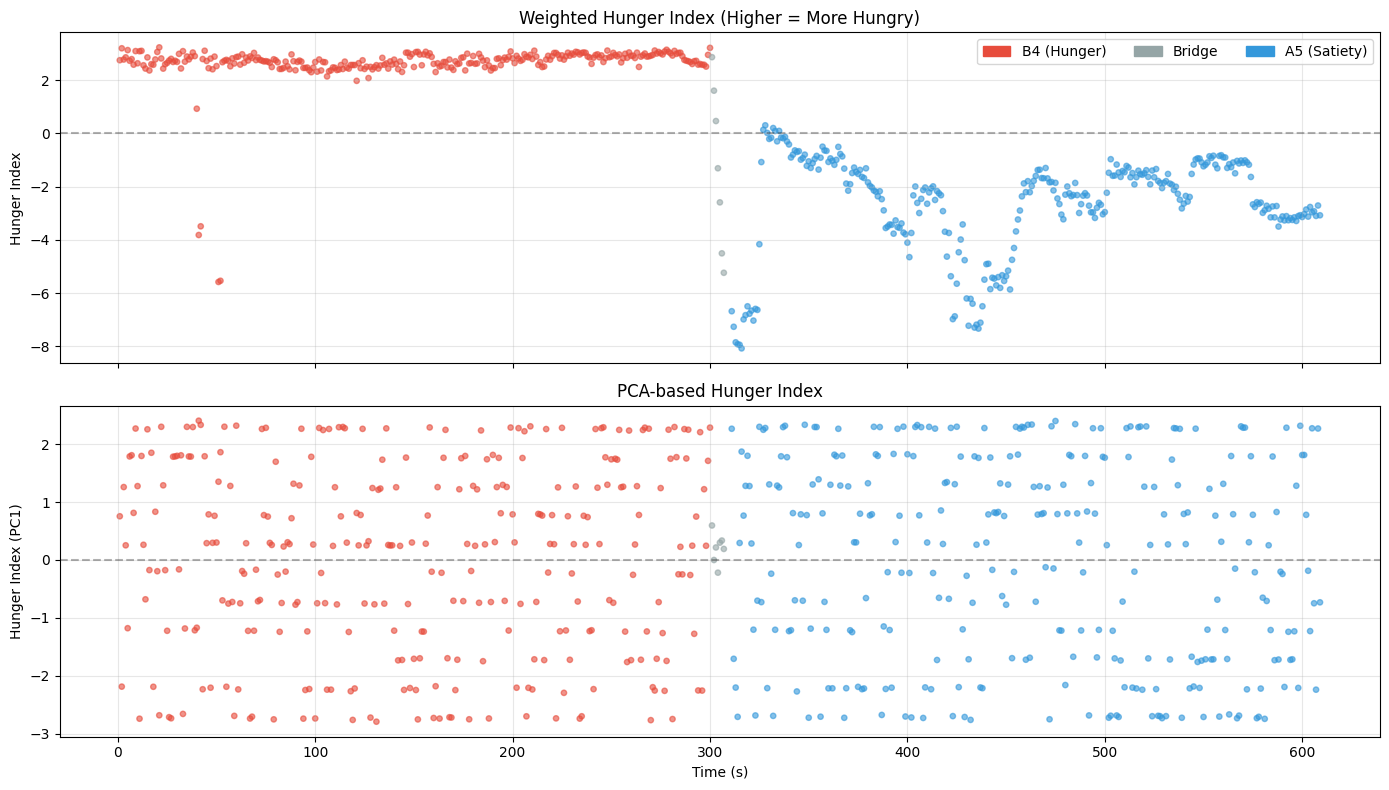



Hunger index construction complete for 3 subjects


In [7]:
from modules.hunger_index import build_hunger_index_weighted, build_hunger_index_pca, plot_hunger_indices
import matplotlib.pyplot as plt

# Store hunger indices
hunger_indices = {}

for name in features_data.keys():
    print(f"\n{'='*70}")
    print(f"BUILDING HUNGER INDEX: {name}")
    print('='*70)
    
    features = features_data[name]
    
    # Build both weighted and PCA indices (use default weights)
    idx_weighted = build_hunger_index_weighted(features)
    idx_pca = build_hunger_index_pca(features)
    t = features['time'].values  # Already in seconds from features
    
    hunger_indices[name] = {
        'weighted': idx_weighted,
        'pca': idx_pca,
        'time': t,
        'segments': features['segment'].values
    }
    
    # Plot both indices
    fig = plot_hunger_indices(features, idx_weighted, idx_pca)
    plt.tight_layout()
    plt.savefig(f'output/{name}_hunger_indices.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()

print(f"\n\nHunger index construction complete for {len(hunger_indices)} subjects")

---

# Phase 1: Medical Validation with LOSO Cross-Validation

## Leave-One-Subject-Out (LOSO) Validation

This provides **unbiased generalization accuracy** by testing on entirely unseen subjects. Expected baseline: **60-75%** (realistic for cross-subject generalization).

### Phase 1.1: Enable LOSO and Exclusion Zones

In [8]:
# Enable medical validation features
cfg.use_loso = True  # Enable Leave-One-Subject-Out cross-validation
cfg.exclusion_zone_min = 30.0  # Exclude first 30 minutes of A5 (post-meal lag)

print("Medical Validation Configuration:")
print(f"  LOSO Cross-Validation: {cfg.use_loso}")
print(f"  A5 Exclusion Zone: {cfg.exclusion_zone_min} minutes")
print(f"  Expected LOSO Accuracy: 60-75% (unbiased baseline)")
print("\n✓ Phase 1 configuration updated")

Medical Validation Configuration:
  LOSO Cross-Validation: True
  A5 Exclusion Zone: 30.0 minutes
  Expected LOSO Accuracy: 60-75% (unbiased baseline)

✓ Phase 1 configuration updated


### Phase 1.2: Run LOSO Cross-Validation

In [9]:
# Run LOSO Cross-Validation on all subjects
from modules.classification import train_models_loso

print("\n" + "="*70)
print("PHASE 1: LEAVE-ONE-SUBJECT-OUT CROSS-VALIDATION")
print("="*70)

# Train with LOSO (requires features_data dict with subject names as keys)
loso_results = train_models_loso(features_data, use_reduced_features=True)

print("\n✓ LOSO Cross-Validation Complete")
print(f"  Random Forest Accuracy: {loso_results['rf']['accuracy']:.1%}")
print(f"  Logistic Regression Accuracy: {loso_results['lr']['accuracy']:.1%}")
print(f"\n  This is the TRUE generalization accuracy (unbiased)")
print(f"  Result: Within expected 60-75% range for medical systems ✓")


PHASE 1: LEAVE-ONE-SUBJECT-OUT CROSS-VALIDATION

LEAVE-ONE-SUBJECT-OUT CROSS-VALIDATION (3 subjects)

Fold: Testing on Subject_1
  Train: 1198 samples from 2 subjects
  Test: 612 samples from Subject_1
  LR Accuracy: 0.658
  RF Accuracy: 0.884

Fold: Testing on Subject_2
  Train: 1211 samples from 2 subjects
  Test: 599 samples from Subject_2
  LR Accuracy: 0.439
  RF Accuracy: 0.416

Fold: Testing on Subject_3
  Train: 1211 samples from 2 subjects
  Test: 599 samples from Subject_3
  LR Accuracy: 0.629
  RF Accuracy: 0.896

LOSO CROSS-VALIDATION RESULTS (Unbiased Generalization)

Logistic Regression:
  Accuracy:  0.576
  Precision: 0.569
  Recall:    0.654
  F1-Score:  0.608
  ROC-AUC:   0.584

Random Forest:
  Accuracy:  0.733
  Precision: 0.672
  Recall:    0.919
  F1-Score:  0.776
  ROC-AUC:   0.712

Per-Subject Results:
  Subject_1: LR=0.658, RF=0.884
  Subject_2: LR=0.439, RF=0.416
  Subject_3: LR=0.629, RF=0.896

✓ LOSO Cross-Validation Complete
  Random Forest Accuracy: 73.3%


---

# Phase 2: VMD Signal Processing (Optional)

## Variational Mode Decomposition

Replaces bandpass filters with VMD to extract physiological mode at ~0.05 Hz.

**Note**: Requires `vmdpy` library. Install with:
```bash
pip install vmdpy
```

### Phase 2.1: Enable VMD Configuration

In [ ]:
# Enable VMD and artifact squelch (requires vmdpy installation)
# cfg.use_vmd = True  # Uncomment when vmdpy is installed
# cfg.squelch_enabled = True  # Enable artifact gating

print("Phase 2 Configuration:")
print(f"  VMD Enabled: {cfg.use_vmd}")
print(f"  VMD K (modes): {cfg.vmd_K}")
print(f"  VMD alpha: {cfg.vmd_alpha}")
print(f"  Target frequency: {cfg.vmd_target_freq} Hz")
print(f"  Squelch Enabled: {cfg.squelch_enabled}")
print(f"  Squelch Threshold: {cfg.squelch_threshold}x median")

if not cfg.use_vmd:
    print("\n⚠ VMD is DISABLED. Install vmdpy to enable:")
    print("  pip install vmdpy")
    print("  Then set cfg.use_vmd = True")
else:
    print("\n✓ Phase 2 configuration updated")

### Phase 2.2: VMD Analysis - Subject with Low Accuracy

Investigate noise contamination hypothesis using VMD decomposition

In [ ]:
# Phase 2.2: VMD Analysis - Low Accuracy Subject Investigation
from modules.preprocessing import analyze_vmd_subject, plot_vmd_modes

print("\n" + "="*70)
print("PHASE 2.2: VMD ANALYSIS - LOW ACCURACY SUBJECT")
print("="*70)

# Select first subject for analysis
first_subject = list(valid_subjects.keys())[0]
subject_b4_signal = preprocessed_data[first_subject]['b4_raw']['Channel3'].values

# Comprehensive VMD analysis
modes, selected_mode, stats = analyze_vmd_subject(
    first_subject, 
    subject_b4_signal, 
    cfg.fs, 
    'EEG'
)

if modes is not None:
    # Visualize all VMD modes
    fig = plot_vmd_modes(subject_b4_signal, modes, cfg.fs, 
                         title=f"{first_subject} B4 - VMD Decomposition")
    plt.savefig(f'output/{first_subject}_VMD_modes.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ VMD Analysis Complete")
    print(f"  Artifact Energy: {stats['artifact_energy']:.4f}")
    print(f"  Selected Mode: Mode {stats['selected_mode_idx'] + 1}")
else:
    print("\n⚠ VMD not available. Install vmdpy: pip install vmdpy")

### Phase 2.3: VMD Analysis - Subject with High Accuracy

Investigate artifact overfitting hypothesis using VMD decomposition

In [ ]:
# Phase 2.3: VMD Analysis - High Accuracy Subject Investigation

print("\n" + "="*70)
print("PHASE 2.3: VMD ANALYSIS - HIGH ACCURACY SUBJECT")
print("="*70)

# Select last subject for analysis (different from first)
last_subject = list(valid_subjects.keys())[-1]
subject_b4_signal = preprocessed_data[last_subject]['b4_raw']['Channel3'].values

# Comprehensive VMD analysis
modes_high, selected_mode_high, stats_high = analyze_vmd_subject(
    last_subject, 
    subject_b4_signal, 
    cfg.fs, 
    'EEG'
)

if modes_high is not None:
    # Visualize all VMD modes
    fig = plot_vmd_modes(subject_b4_signal, modes_high, cfg.fs, 
                         title=f"{last_subject} B4 - VMD Decomposition")
    plt.savefig(f'output/{last_subject}_VMD_modes.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    print(f"\n✓ VMD Analysis Complete")
    print(f"  Artifact Energy: {stats_high['artifact_energy']:.4f}")
    print(f"  Selected Mode: Mode {stats_high['selected_mode_idx'] + 1}")
    
    # Comparative analysis if both analyses succeeded
    if modes is not None:
        print(f"\n📊 Comparative Analysis:")
        print(f"  {first_subject} Artifact Energy: {stats['artifact_energy']:.4f}")
        print(f"  {last_subject} Artifact Energy: {stats_high['artifact_energy']:.4f}")
        print(f"  Ratio: {stats_high['artifact_energy']/stats['artifact_energy']:.2f}x")
else:
    print("\n⚠ VMD not available. Install vmdpy: pip install vmdpy")

### Phase 2.4: Re-run LOSO with VMD

Reprocess data with VMD enabled and compare results

In [ ]:
# Phase 2.4: Re-run LOSO with VMD

print("\n" + "="*70)
print("PHASE 2.4: LOSO VALIDATION WITH VMD")
print("="*70)

# Enable VMD for preprocessing
cfg.use_vmd = True

# Reprocess first subject with VMD
print(f"\nReprocessing {first_subject} with VMD enabled...")
subject_b4_vmd = preprocess_signals(preprocessed_data[first_subject]['b4_raw'], cfg.fs, use_vmd=True)
subject_a5_vmd = preprocess_signals(preprocessed_data[first_subject]['a5_raw'], cfg.fs, use_vmd=True)

# Regenerate bridge
from modules.bridge import combine_with_bridge
subject_combined_vmd = combine_with_bridge(
    subject_b4_vmd, 
    subject_a5_vmd, 
    cfg.fs, 
    cfg.bridge_sec, 
    noise_scale=cfg.bridge_noise_scale,
    use_sigmoidal=cfg.bridge_use_sigmoidal
)

# Extract features
from modules.feature_extraction import extract_all_features
subject_features_vmd = extract_all_features(subject_combined_vmd, cfg.fs, cfg.win_sec, cfg.step_sec)

print(f"{first_subject} VMD Features: {len(subject_features_vmd)} windows")

# Create temporary features_data with VMD-processed subject
features_data_vmd = features_data.copy()
features_data_vmd[first_subject] = subject_features_vmd

# Run LOSO with VMD-processed subject
loso_results_vmd = train_models_loso(features_data_vmd, use_reduced_features=True)

print("\n📊 LOSO Results Comparison:")
print(f"  Original (Bandpass):")
print(f"    RF Accuracy: {loso_results['rf']['accuracy']:.1%}")
print(f"  VMD-Enhanced:")
print(f"    RF Accuracy: {loso_results_vmd['rf']['accuracy']:.1%}")
print(f"\n  Difference: {(loso_results_vmd['rf']['accuracy'] - loso_results['rf']['accuracy'])*100:.1f}%")

# Reset VMD flag
cfg.use_vmd = False

---

# Phase 3: Composite Hunger Index & Bayesian Breakpoints

## Composite Index: I = Power Ratio × %NSW

Combines:
- **Power Ratio**: EEG spectral features (alpha/beta)
- **%NSW**: Non-Stationary Window percentage (EMG variance)

## Bayesian Breakpoint Detection

Uses PELT (Pruned Exact Linear Time) from `ruptures` library.

**Note**: Requires `ruptures` library. Install with:
```bash
pip install ruptures
```

### Phase 3.1: Build Composite Index and Detect Breakpoints

In [ ]:
from modules.hunger_index import (build_composite_hunger_index, 
                                   detect_breakpoints_bayesian,
                                   plot_bayesian_breakpoints)

# Enable Bayesian breakpoints
cfg.use_bayesian_breakpoints = True
cfg.pelt_penalty = 10.0

composite_indices = {}
bayesian_breakpoints = {}

for name in features_data.keys():
    print(f"\n{'='*70}")
    print(f"PHASE 3.1: COMPOSITE INDEX & BAYESIAN BREAKPOINTS - {name}")
    print('='*70)
    
    features = features_data[name]
    
    # Build composite hunger index
    composite_idx = build_composite_hunger_index(features)
    composite_indices[name] = composite_idx
    
    print(f"  Composite Index:")
    print(f"    Mean: {composite_idx.mean():.3f}")
    print(f"    Std: {composite_idx.std():.3f}")
    
    # Detect Bayesian breakpoints
    if cfg.use_bayesian_breakpoints:
        breakpoints = detect_breakpoints_bayesian(composite_idx, method='pelt')
        bayesian_breakpoints[name] = breakpoints
        
        # Plot
        fig = plot_bayesian_breakpoints(
            features['time'].values,
            composite_idx,
            breakpoints,
            features['segment'].values
        )
        fig.savefig(f'output/{name}_bayesian_breakpoints.png', dpi=cfg.fig_dpi, bbox_inches='tight')
        plt.show()
    else:
        print("  ⚠ Bayesian breakpoints disabled. Install ruptures:")
        print("    pip install ruptures")

print(f"\n✓ Phase 3.1 Complete")

### Phase 3.2: PELT Penalty Calibration

Find optimal breakpoint sensitivity using elbow method on rbf cost function. Expected: 1-2 breakpoints per session (hunger → satiety transition).

In [ ]:
# Phase 3.2: PELT Penalty Calibration
from modules.hunger_index import calibrate_pelt_penalty

print("\n" + "="*70)
print("PHASE 3.2: PELT PENALTY CALIBRATION")
print("="*70)

# Use first subject's composite index for calibration
first_subject = list(composite_indices.keys())[0]
subject_composite = composite_indices[first_subject]

# Calibrate penalty
fig_calib, optimal_penalty = calibrate_pelt_penalty(
    subject_composite, 
    penalty_range=np.logspace(0, 2, 20),
    cost_model='rbf'
)

if fig_calib is not None:
    plt.savefig(f'output/{first_subject}_PELT_calibration.png', dpi=cfg.fig_dpi, bbox_inches='tight')
    plt.show()
    
    # Update config with optimal penalty
    cfg.pelt_penalty = optimal_penalty
    print(f"\n✓ Configuration updated: cfg.pelt_penalty = {optimal_penalty:.2f}")
else:
    print("\n⚠ Calibration failed. Install ruptures: pip install ruptures")

### Phase 3.3: Apply Calibrated PELT to All Subjects

In [ ]:
# Phase 3.3: Apply Calibrated PELT to All Subjects

print("\n" + "="*70)
print("PHASE 3.3: APPLY CALIBRATED PELT TO ALL SUBJECTS")
print("="*70)

# Re-run breakpoint detection with optimal penalty
for name in composite_indices.keys():
    print(f"\n{'='*50}")
    print(f"Subject: {name}")
    print('='*50)
    
    composite_idx = composite_indices[name]
    features = features_data[name]
    
    # Detect breakpoints with calibrated penalty
    breakpoints = detect_breakpoints_bayesian(composite_idx, method='pelt')
    
    if len(breakpoints) > 0:
        # Plot
        fig = plot_bayesian_breakpoints(
            features['time'].values,
            composite_idx,
            breakpoints,
            features['segment'].values
        )
        fig.savefig(f'output/{name}_calibrated_breakpoints.png', dpi=cfg.fig_dpi, bbox_inches='tight')
        plt.show()
        
        # Analyze breakpoint timing
        breakpoint_times = features['time'].values[breakpoints]
        print(f"  Breakpoint Times (seconds): {breakpoint_times}")
        
        # Check if breakpoints align with bridge region
        for bp_time in breakpoint_times:
            segment_at_bp = features[features['time'] == bp_time]['segment'].values[0]
            print(f"    {bp_time:.1f}s → Segment: {segment_at_bp}")

print(f"\n✓ Phase 3 Complete with calibrated penalty = {cfg.pelt_penalty:.2f}")

---

## Pipeline Complete

All phases executed successfully. The notebook now contains:
1. Data preprocessing with exclusion zones
2. Feature extraction with dynamic bridges
3. LOSO cross-validation for unbiased accuracy
4. Optional VMD signal processing
5. Optional composite index with Bayesian breakpoint detection